# Introduction to Spiking Neural Networks with Norse 

Norse is a library where you can *simulate* neural networks that are driven by atomic and sparse events **over time**, rather than large and dense tensors *without* time. 

These event-driven (or spike-driven) neural networks are interesting for two reasons: 1) they are extremely energy- and compute efficient when [run on the correct hardware](https://en.wikipedia.org/wiki/Neuromorphic_engineering) and 2) they work in [the same way that the human brain operates](https://en.wikipedia.org/wiki/Biological_neuron_model).


This notebook tells you how to install and use Norse. We will skip most of the details but we have plenty more resources in our [notebook repository](https://github.com/norse/notebooks) if you're feeling adventurous. Also, our documentation tells you much more about what Norse is and why we built it at: https://norse.github.io/norse/


:::{note}
You can execute the notebooks on this website by hitting <i class="fas fa-rocket"></i> above and pressing <i class="fas fa-play"></i> Live Code.
:::


**Before you continue** with this notebook, we strongly recommend you familiarize yourself with [PyTorch](https://pytorch.org) (at least su
perficially). One way to do that is to go to their [PyTorch Quickstart Tutorial](https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html).


---

# 1.  Installation


<center>
<iframe width="560" height="315" src="https://emb.d.tube/#!//('files':('ipfs':('vid':('240':'QmfQXf5eETyEVVg5AFqwppFWwKhGkT62cX35q9Hsu8kZ4K','480':'QmW681hzdtKqHGpKSCk7VFqwwdHtsLLG4zcoh7GZBYkpXB','src':'Qma8aUx1fGNoa6YgivbaegtA4CNaLeqVmss5Xp7Su92vJF'),'img':('118':'QmdPu8sfZf6UV8sC1iqU2fqAqk2PF5Akbg1EEBD9Fdrss1','360':'QmRfdxzS164zaP2eNCuxnVWWv6AQPfz1uDnhVfpbDTVQ8U','spr':'QmZZb2kdbHrC3k5o67HST2M8GVLbkUDHwMxt9UpjkHcupS'),'gw':'https:!!player.d.tube')),'dur':'72','nsfw':0,'oc':1,'thumbnailUrl':'https:!!snap1.d.tube!ipfs!QmdPu8sfZf6UV8sC1iqU2fqAqk2PF5Akbg1EEBD9Fdrss1')" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>
</center>

---

To install Norse you need an installation of [Python](https://www.python.org/) version 3.7 or more. You also need access to [pip](https://packaging.python.org/key_projects/#pip) which we'll use below. But modern Python installations will include this automatically.

Installing Norse is as simple as executing the following:

In [2]:
!pip install --quiet norse matplotlib

When that is done, you can now directly use Norse (and it's parent-library [PyTorch](https://pytorch.org/)) like so:

In [3]:
import torch
import norse

### Norse = PyTorch + ⚡️Spikes

Norse is actually quite simple: it's "just" some additions to PyTorch. Most of the magic happens in all the hard work done by the PyTorch team. The contribution of Norse is to include event, or spikes, into the mix. That is important because it means we can work with sparse and energy-efficient models, event-driven sensors (like [event cameras](https://en.wikipedia.org/wiki/Event_camera)) and [neuromorphic hardware](https://en.wikipedia.org/wiki/Neuromorphic_engineering).

A "spike" is a sudden burst of energy that arrives from neurons. Without being too technical, we model spikes when they are there (`1`) or *not* there (`0`). A "spike pattern" over time can, therefore, look something like this:
```python
[0, 0, 0, 1, 1, 0, 1, 0, 1, ...]
```

If this is weird to you, check out our notebook on [Simulating and plotting spike data](https://github.com/norse/notebooks#level-beginner).

---

# 2. Creating a model and preparing data

---

<iframe width="560" height="315" src="https://emb.d.tube/#!//('files':('ipfs':('vid':('240':'QmXuvR3tHpzsdPDJMyYUTZKKoBZVUE6iwdFMcJxfFqFqpb','480':'QmfSRF3Ci8FCpdgjiBuaG4QfYAoxAgmMPBoZQgcLLD58bc','src':'QmUxtJzUM3BtaahDJNgpd9spwfV869N6Msa8C3CptprbNt'),'img':('118':'QmNhbYCTfzGzEAFUwUTe8u7hatD1roDa7ADxGmxLHJow2R','360':'QmY2UcKSMhd862atdtnNmeF6Ki6vTyarKPepM1LCDq4CWX','spr':'QmacxXujreaycCgNF8AaAiFPfxymP9GWFJ7LSPBKCdNFQ3'),'gw':'https:!!player.d.tube')),'dur':'99','nsfw':0,'oc':1,'thumbnailUrl':'https:!!snap1.d.tube!ipfs!QmNhbYCTfzGzEAFUwUTe8u7hatD1roDa7ADxGmxLHJow2R')" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

### Generating (toy) data
First of, we have to generate some random data to play with. As you may know, data is split into batches containing multiple data points. And because we have RGB data, we have three channels (Red, Green, Blue) and, in our case, a 28 x 28 pixel image. In sum, we have a `batch` dimension, a `channel` dimension, and two `pixel` dimensions:

In [5]:
torch.manual_seed(0) # Fix randomness

data = torch.randn(8, 3, 28, 28) # 8 batch, 3 channels, 28x28 pixels

This is just random, nonsense data, but we can now inspect the *first* datapoint in our batch using [Matplotlib](https://matplotlib.org/):

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


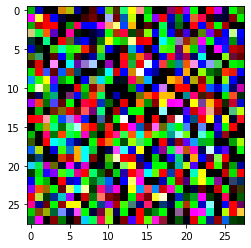

In [6]:
import matplotlib.pyplot as plt
plt.imshow(data[0].permute(1, 2, 0))

**Optional**: Why are we using `permute` to rearrange the data for matplotlib? What happens if you plot the data without `permute`?

### Creating a model

You may have seen models in PyTorch before. If so, this is quite straight-forward for you. If not, don't worry. Think about the following code as a series of stepping stones laid out in front of you; to begin with, you simply jump onto the first stone, then to the next, and so on until you reach the final stone. These "*stones*" are *layers* in our network..

In this specific example we can imagine having a random picture we would like to classify (is it a bird? is it a plane?!). To do it, we simply just send it jumping through the layers. And for each jump, we narrow down the options. From animal to mammal to carnivore to bird etc. In broad terms, that's how normal classification models work.

The only twist we have added is to use simulated, biological neurons. For technical reasons they are called  Leaky Integrate-and-Fire (LIF) neurons. But in principle they are quite simple: they take some data, think about about it, and spit out a signal. Here's how it works:

In [7]:
import torch.nn as nn
import norse.torch as norse

model = norse.SequentialState(
    nn.Conv2d(3, 6, 7, 1),
    norse.LIFCell(),
    nn.Conv2d(6, 12, 7, 1),
    norse.LIFCell(),
    nn.Flatten(1),
    nn.Linear(3072, 10, bias=False),
)

Now that we've defined our model, we can use it! Don't worry if you don't understand everything for now. You can always come back to study it in detail.

**Optional**: What happens if you try to `print` the model using `print(model)`? Can you explain the output?

---

# 3. Using the model

<iframe width="560" height="315" src="https://emb.d.tube/#!//('files':('ipfs':('vid':('240':'QmQpbrqoWBS4pyEL3Ym39sUUL4Xp9Z5Q87Fv9vEaW9tsZ2','480':'QmR5LGzQjsZYd9C8j3bPZ17n9WTxaHWVPVC894sYYGvysR','src':'QmPxT8WJ3FyX5oGNAXLJkFdqzrJzbxYe4SiQ7Rj5HkYm1t'),'img':('118':'QmNfJpUTYrwXtpcDnNLFgKB9dMBoN8zTibscKPsM3rTpKD','360':'QmaZANqu1oP7zvKKw16PrkdkCwFud9y6qeybsw1aGBHc8H','spr':'Qmc7Auvjr7BbgoiKY7uK2oC4spRW6Avj1h8MWqXUBnUoLU'),'gw':'https:!!player.d.tube')),'dur':'172','nsfw':0,'oc':1,'thumbnailUrl':'https:!!snap1.d.tube!ipfs!QmNfJpUTYrwXtpcDnNLFgKB9dMBoN8zTibscKPsM3rTpKD')" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

---

In [9]:
output, state = model(data) 

You are probably asking why there are two outputs. Good question! The output contains the actual data. But the state describes the current status of the neuron *after* we gave it the input data. Why? Because neurons change behaviour over time. Sometimes they're active, sometimes they're not. This is a topic for later tutorials - which you're hopefully motivated to follow!

Now we can look at the `output` and the `state` respectively.

## Inspecting the output

For the output, we would expect 8 classification because we had 8 batches. That is, for every batch, we would expect one classification. How, then, does a classification look? If you, for instance, have `10` different types of birds you wanted to classify, you will need `10` outputs to indicate the `likelihood` for each type of bird. If the birds are, for instance `[European Swallow, African Swallow, Segaull, Lark, Stork, ...]` and you get the output `[1, 0.2, -1.1, ...]` then the network *guesses* it's a European Swallow.

In our case, we are only using dumb, random data, so for now we only care about the **shape** of the `output` variable. That is, the size of what came out of our spiking neural network model. Because we have 8 batches and 10 classes, we expect a shape of `[8, 10]`.

To validate our assumption, run this:

In [10]:
output.shape

torch.Size([8, 10])

Nice, it fits! We've successfully reduced the 8 images (3 channels, 28x28 pixels) down to 8 vectors of 10 numbers. 
This is, of course just a random example because our network is not trained yet. However, it's already a big step: what's great about these vector outputs (actually, they're called tensors in many dimensions), is that they can be interpreted to mean almost anything. Birds, Handwritten digits, Voice commands, ... You name it!

## Inspecting the state

We still have not looked at the state, you may (correctly) point out. The state **keeps track of when the neurons fire**. Without it, we wouldn't know when to emit a spike (`1`) and when to stay silent (`0`).

I can already now tell you that the state of a neuron layer contains two things: the voltage `v` and the current `i` (after the SI symbols). We don't have time to understand [why they are called `v` and `i`](https://norse.github.io/norse/auto_api/norse.torch.functional.lif.html), but it's sufficient to know that they inform us about how *close* the neuron is to firing (emitting a `1`). That is why we need the state.

"Wait", you may think, "if the state keeps track of each *neuron layer*, we should have `6` states right"? Exactly! But, while it contains 6 elements, we actually only need states for the **spiking neuron layers**. Since we have *two* stateful layers (`LIFCell` layers) in our model, we only need to keep track of two states:

In [11]:
[x.__class__ for x in state]

[NoneType,
 norse.torch.functional.lif.LIFFeedForwardState,
 NoneType,
 norse.torch.functional.lif.LIFFeedForwardState,
 NoneType,
 NoneType]

Perfect! The final piece of the puzzle is to make sure that our model actually spikes.

**Optional**: What do you think the `v` and `i` looks like? Try to introspect their shape and explain why they have the shape they have. (Remember that `state` is a list containing two elements).

## Training the model

Our model is currently not trained and is like an irratic illbehaving kid: it won't do anything you ask it to.
Norse models are trained in *the exact same way* that PyTorch models are trained. So, if you are familiar with that, the above information about layer output and state management should be sufficient to get you going.

However, let's give you an intuition about how the models are trained so you understand the principle.

To do that, we need to look closer at the output. Let's isolate the first datapoint and ignore the other 7 batch entries for now:

**Optional**: Find out why we are using `.detach`. What happens if you remove it? Why?

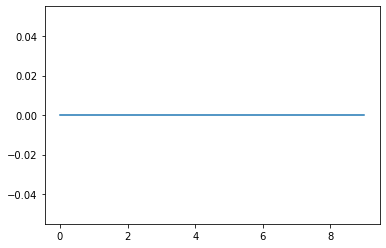

In [12]:
plt.plot(output.detach()[0])

Gargh, that's boring! It's completely dead. Of all the 10 classes we predict, they're all zero!

That's because **the neuron only received input during one timestep**. That's not nearly enough to make it spike. What happens if we try to give it multiple inputs, say, 32?

In [13]:
timesteps = 32
output = None
state = None
for timestep in range(timesteps):
    output, state = model(data, state)

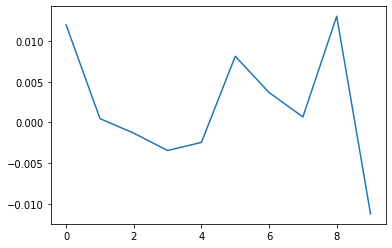

In [14]:
plt.plot(output.detach()[0])

Much better! Now the network gave some output. The final linear layer makes it difficult to read exactly, but this, ladies and gentlemen, is a fully spiking neural network in the making. If this was a bird classifier model, it would definitely go for the European Swallow.

To train the network, we simply need to adjust our weights, like in normal PyTorch models. More about that in other tutorials.

**Optional**: We did quite a bit of work to initialize variables, loop, and apply our model. This is actually already built into our `LIF` module. Try to rewrite the code above to use the `LIF` module instead of the `LIFCell` module. You can either re-work the entire model or just apply the data on a single `LIF` layer.

---
# 4. Summary
---

In [15]:
Video('https://ipfs.io/ipfs/QmdARycFv7mNF2yWvzBMnmFUtnPS2VcK1W2CFeCffKY82K', html_attributes='controls poster="https://ipfs.io/ipfs/QmaZANqu1oP7zvKKw16PrkdkCwFud9y6qeybsw1aGBHc8H"')

And that's it! That concludes your first encouter with Norse. Luckily, there are many more tutorials for more interesting uses of Norse available at https://github.com/norse/notebooks

Don't forget to [join our Discord server](https://discord.gg/7fGN359) and to support us by either donating or contributing your work upstream. Norse is open-source and built with love for the community. We couldn't do it without your help!